In [2]:
%load_ext autoreload
%autoreload 2

import abc
import numpy as np
import matplotlib
import scipy.linalg
matplotlib.rcParams["xtick.labelsize"] = 20
matplotlib.rcParams["ytick.labelsize"] = 20
matplotlib.rcParams["image.cmap"] = "inferno"
matplotlib.rcParams["axes.titlesize"] = 25
matplotlib.rcParams["axes.labelsize"] = 25
from matplotlib import pyplot as plt
from typing import Optional

import modulated_kerr_cavity
import modulated_tls
import floquet_analysis
import pulse
import single_photon_scattering
import two_photon_scattering

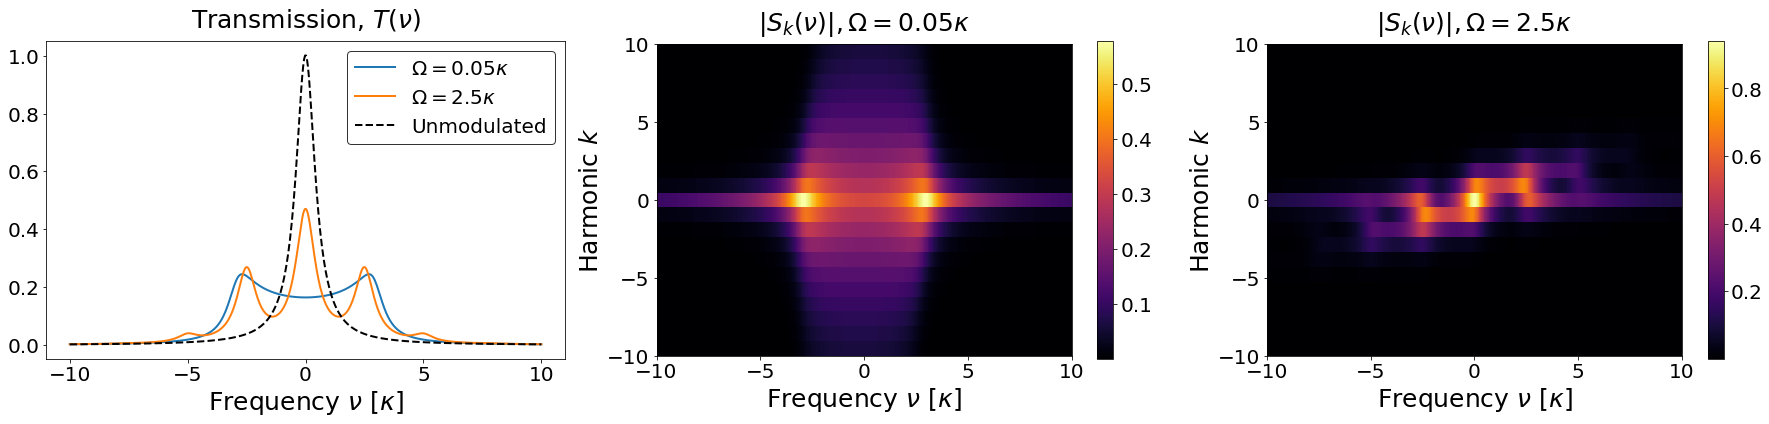

In [7]:
gamma = 1.0
chi = 1.0
delta_max = 3 * gamma 
inp_freqs = np.linspace(-10, 10, 500) * gamma

# Unmodulated.
freq_slow = 0.05 * gamma
num_harmonics = 500
delta = pulse.SinusoidalPulse(0, 0.0, 0.0, freq_slow)
sys_obj = modulated_kerr_cavity.ModulatedKerrCavity(
    0, gamma, chi, delta)
floquet_obj = floquet_analysis.FloquetAnalyzer(sys_obj, num_harmonics)
_, gfunc_unmod = single_photon_scattering.compute_single_ph_gfunc(
        floquet_obj, inp_freqs)
tran_unmod = 0.25 * np.sum(np.abs(gfunc_unmod)**2, axis=1)


# Slow modulation regime.
freq_slow = 0.05 * gamma
num_harmonics = 500
delta = pulse.SinusoidalPulse(0, delta_max, 0.0, freq_slow)
sys_obj = modulated_kerr_cavity.ModulatedKerrCavity(
    0, gamma, chi, delta)
floquet_obj = floquet_analysis.FloquetAnalyzer(sys_obj, num_harmonics)
_, gfunc_slow = single_photon_scattering.compute_single_ph_gfunc(
        floquet_obj, inp_freqs)
tran_slow = 0.25 * np.sum(np.abs(gfunc_slow)**2, axis=1)

# Fast modulation regime.
freq_fast = 2.5 * gamma
num_harmonics = 500
delta = pulse.SinusoidalPulse(0, delta_max, 0.0, freq_fast)
sys_obj = modulated_kerr_cavity.ModulatedKerrCavity(
    0, gamma, chi, delta)
floquet_obj = floquet_analysis.FloquetAnalyzer(sys_obj, num_harmonics)
_, gfunc_fast = single_photon_scattering.compute_single_ph_gfunc(
        floquet_obj, inp_freqs)
tran_fast = 0.25 * np.sum(np.abs(gfunc_fast)**2, axis=1)

plt.figure(figsize=(25, 6))
plt.subplot(1, 3, 1)
plt.plot(inp_freqs, tran_slow, linewidth=2, label=r"$\Omega = 0.05\kappa$")
plt.plot(inp_freqs, tran_fast, linewidth=2, label=r"$\Omega = 2.5\kappa$")
plt.plot(inp_freqs, tran_unmod, '--k', linewidth=2, label=r"Unmodulated")
plt.xlabel(r"Frequency $\nu\ [\kappa]$")
plt.title(r"Transmission, $T(\nu)$", y=1.025)
plt.legend(fontsize=20, edgecolor="k")

plt.subplot(1, 3, 2)
plt.imshow(np.abs(gfunc_slow[:, 490:511]).T,
           aspect=0.75, interpolation="None",
           extent=[-10, 10, -10, 10]);
plt.colorbar()
plt.title(r"$|S_k(\nu)|, \Omega = 0.05\kappa$", y=1.025)
plt.ylabel(r"Harmonic $k$")
plt.xlabel(r"Frequency $\nu\ [\kappa]$")


plt.subplot(1, 3, 3)
plt.imshow(np.abs(gfunc_fast[:, 490:511]).T,
           aspect=0.75, interpolation="None",
           extent=[-10, 10, -10, 10]);

plt.colorbar()
plt.title(r"$|S_k(\nu)|, \Omega = 2.5\kappa$", y=1.025)
plt.ylabel(r"Harmonic $k$")
plt.xlabel(r"Frequency $\nu\ [\kappa]$")
 
plt.tight_layout()
plt.savefig("results/theory_figures/single_photon.pdf")

In [56]:
gamma = 1.0
chis = [0.2, 1.0, 5.0]
delta_max = 3 * gamma
freq = 2.5 * gamma
num_harmonics = 500
out_deltas = np.linspace(-7.5, 7.5, 300) * gamma
delta = pulse.SinusoidalPulse(0, delta_max, 0.0, freq)
conn_smats = []
for chi in chis:
    sys_obj = modulated_kerr_cavity.ModulatedKerrCavity(
        0, gamma, chi, delta)
    floquet_obj = floquet_analysis.FloquetAnalyzer(sys_obj, num_harmonics)
    conn_smat = two_photon_scattering.compute_connected_smat(
        floquet_obj, np.array([0]), out_deltas, [-1, 0, 1])
    conn_smats.append(conn_smat)
    
    
tls_obj = modulated_tls.ModulatedTwoLevelSystem(
        0, gamma, delta)
floquet_obj = floquet_analysis.FloquetAnalyzer(tls_obj, num_harmonics)
conn_smat_tls = two_photon_scattering.compute_connected_smat(
        floquet_obj, np.array([0]), out_deltas, [-1, 0, 1])

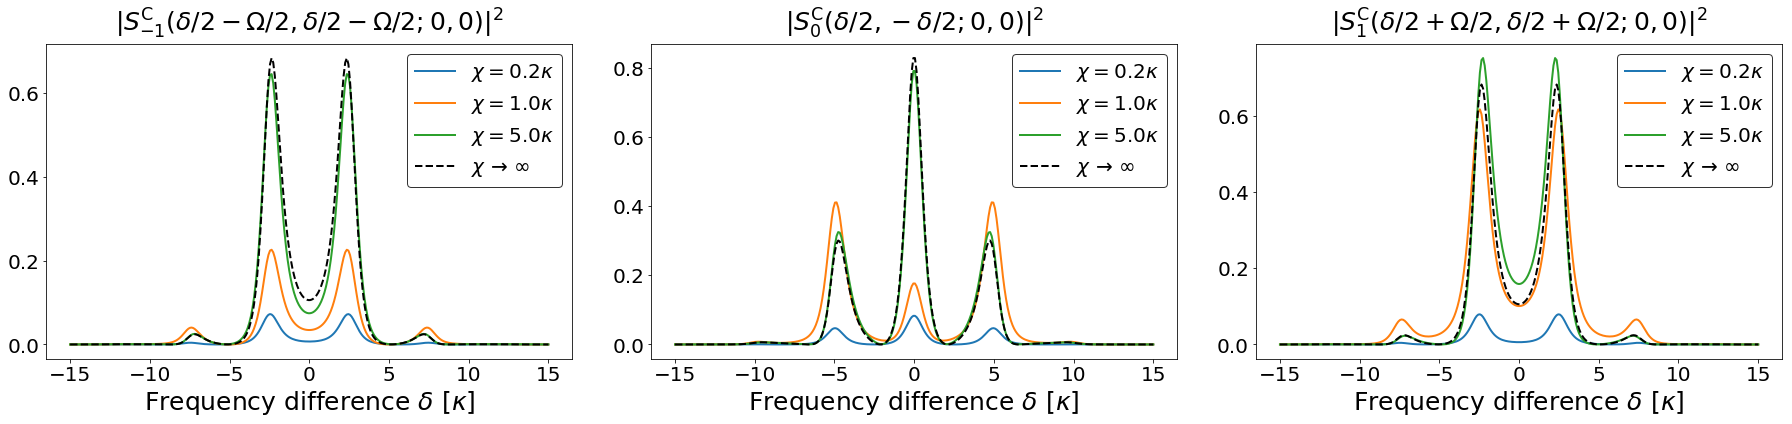

In [61]:
plt.figure(figsize=(25, 6))
plt.subplot(1, 3, 1)
for k, chi in enumerate(chis):
    plt.plot(2 * out_deltas, np.abs(conn_smats[k][0][0])**2, linewidth=2,
             color="C{}".format(k), label=r"$\chi = {}\kappa$".format(chi))
plt.plot(2 * out_deltas, np.abs(conn_smat_tls[0][0])**2, '--k', linewidth=2,
         label=r"$\chi\ \to\ \infty$")
plt.xlabel("Frequency difference $\delta\ [\kappa]$")
plt.title(r"$|S_{-1}^\mathrm{C}(\delta / 2 - \Omega / 2, \delta / 2 - \Omega / 2; 0, 0)|^2$",
          y=1.02)
plt.legend(fontsize=20, edgecolor="k")

plt.subplot(1, 3, 2)
for k, chi in enumerate(chis):
    plt.plot(2 * out_deltas, np.abs(conn_smats[k][1][0])**2, linewidth=2,
             color="C{}".format(k), label=r"$\chi = {}\kappa$".format(chi))
plt.plot(2 * out_deltas, np.abs(conn_smat_tls[1][0])**2, '--k', linewidth=2,
         label=r"$\chi\ \to\ \infty$")
plt.xlabel("Frequency difference $\delta\ [\kappa]$")
plt.title(r"$|S_{0}^\mathrm{C}(\delta / 2, - \delta / 2; 0, 0)|^2$",
          y=1.02)
plt.legend(fontsize=20, edgecolor="k")

plt.subplot(1, 3, 3)
for k, chi in enumerate(chis):
    plt.plot(2 * out_deltas, np.abs(conn_smats[k][2][0])**2, linewidth=2,
             color="C{}".format(k), label=r"$\chi = {}\kappa$".format(chi))
plt.plot(2 * out_deltas, np.abs(conn_smat_tls[2][0])**2, '--k', linewidth=2,
         label=r"$\chi\ \to\ \infty$")
plt.xlabel("Frequency difference $\delta\ [\kappa]$")
plt.title(r"$|S_{1}^\mathrm{C}(\delta / 2 + \Omega / 2, \delta / 2 + \Omega / 2; 0, 0)|^2$",
          y=1.02)
plt.legend(fontsize=20, edgecolor="k")

plt.tight_layout()
plt.subplots_adjust(wspace=0.15)
plt.savefig("results/theory_figures/two_photon.pdf")

In [9]:
def kerr_cavity_smat(gamma, chi, nu, deltas) -> np.ndarray:
    prefac = 2 * gamma**2 / (np.pi) * (
        1 / (0.5 * gamma - 1.0j * nu + 1.0j * chi) -
        1 / (0.5 * gamma - 1.0j * nu))
    delta_dep = 1 / ((0.5 * gamma - 1.0j * nu)**2 + deltas**2)
    return prefac * delta_dep

Text(0, 0.5, '$|S_0^C(\\delta; \\nu)|$')

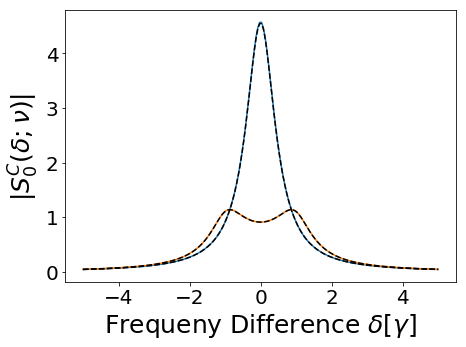

In [110]:
# Computing the connected part of the scattering matrix.
deltas = np.linspace(-5, 5, 200)
conn_smat = two_photon_scattering.compute_connected_smat(
    floquet_obj, np.array([0, 1.0]), deltas, [0])

plt.figure(figsize=(7, 5))
plt.plot(deltas, np.abs(conn_smat[0][0]))
plt.plot(deltas, np.abs(conn_smat[0][1]))
plt.plot(deltas, np.abs(kerr_cavity_smat(gamma, chi, 0, deltas)), color="k", linestyle="--")
plt.plot(deltas, np.abs(kerr_cavity_smat(gamma, chi, 1.0, deltas)), color="k", linestyle="--" )
plt.xlabel("Frequeny Difference $\delta [\gamma]$")
plt.ylabel(r"$|S_0^C(\delta; \nu)|$")

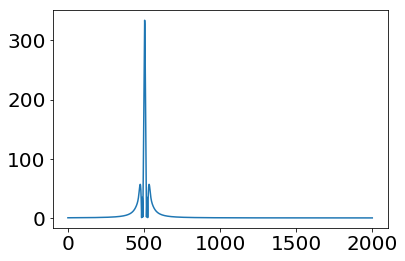

In [40]:
plt.plot((np.abs(psi_corr_0_fft)[4000:6000]))

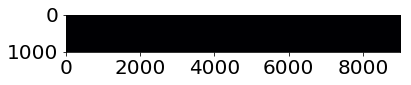

In [177]:
plt.imshow(np.abs(psi_corr_fft))

In [178]:
psi_corr_fft

array([[-1.92853347+4.62650746e-04j, -1.93937151+4.64920546e-04j,
        -1.95060841+4.67284277e-04j, ..., -1.95060841+4.67284277e-04j,
        -1.93937151+4.64920546e-04j, -1.92853347+4.62650746e-04j],
       [-0.63873342+4.76464717e+00j, -0.63944636+4.77059985e+00j,
        -0.64014678+4.77659213e+00j, ..., -0.64014678+4.77659213e+00j,
        -0.63944636+4.77059985e+00j, -0.63873342+4.76464717e+00j],
       [ 2.85120297+6.29482118e-01j,  2.85258774+6.29720825e-01j,
         2.85382753+6.29926637e-01j, ...,  2.85382753+6.29926637e-01j,
         2.85258774+6.29720825e-01j,  2.85120297+6.29482118e-01j],
       ...,
       [-0.2948788 -1.02167758e+00j, -0.2949079 -1.02183505e+00j,
        -0.29491081-1.02189139e+00j, ..., -0.29491081-1.02189139e+00j,
        -0.2949079 -1.02183505e+00j, -0.2948788 -1.02167758e+00j],
       [ 2.8509372 -6.30855497e-01j,  2.85232186-6.31094774e-01j,
         2.85356153-6.31301087e-01j, ...,  2.85356153-6.31301087e-01j,
         2.85232186-6.31094774e-01j